# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code for predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

We will explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

Detailed data description:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
data["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

data["flight_day"] = data["flight_day"].map(mapping)

In [6]:
data["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder instance
label_encoder = LabelEncoder()
# Label encode the airport codes
data['Encoded_Airport'] = label_encoder.fit_transform(data['route'])

# Calculate mean target variable for each airport code
airport_target_mean = data.groupby('Encoded_Airport')['booking_complete'].mean()

# Map the mean values back to the original airport codes
data['Airport_Target_Mean'] = data['Encoded_Airport'].map(airport_target_mean)

data['BookingCountry_encoded'] = label_encoder.fit_transform(data['booking_origin'])

In [8]:
data = data.drop('route', axis=1)
data = data.drop('booking_origin', axis=1)
from sklearn.model_selection import train_test_split

# Feature Engineering: 
data['flight_time'] = data['flight_hour'] + data['flight_day']
data = data.drop('flight_hour', axis=1)
data = data.drop('flight_day', axis=1)

# Encoding Categorical Variables: Using one-hot encoding
data = pd.get_dummies(data, columns=['sales_channel', 'trip_type'], drop_first=True)

# Define features (X) and target (y)
X = data.drop('booking_complete', axis=1)
y = data['booking_complete']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(n_estimators=100)

# Train the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     10648
           1       0.74      0.34      0.46      1852

    accuracy                           0.88     12500
   macro avg       0.81      0.66      0.70     12500
weighted avg       0.87      0.88      0.87     12500



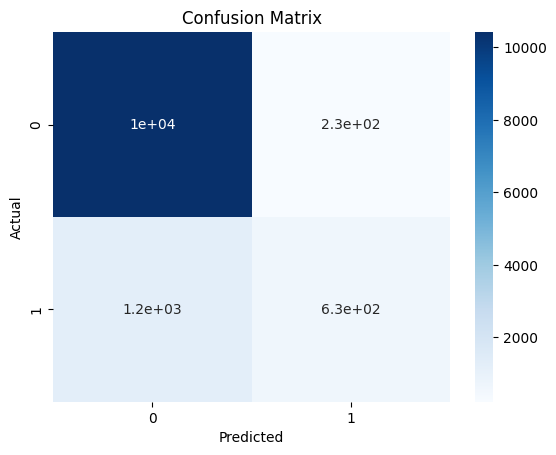

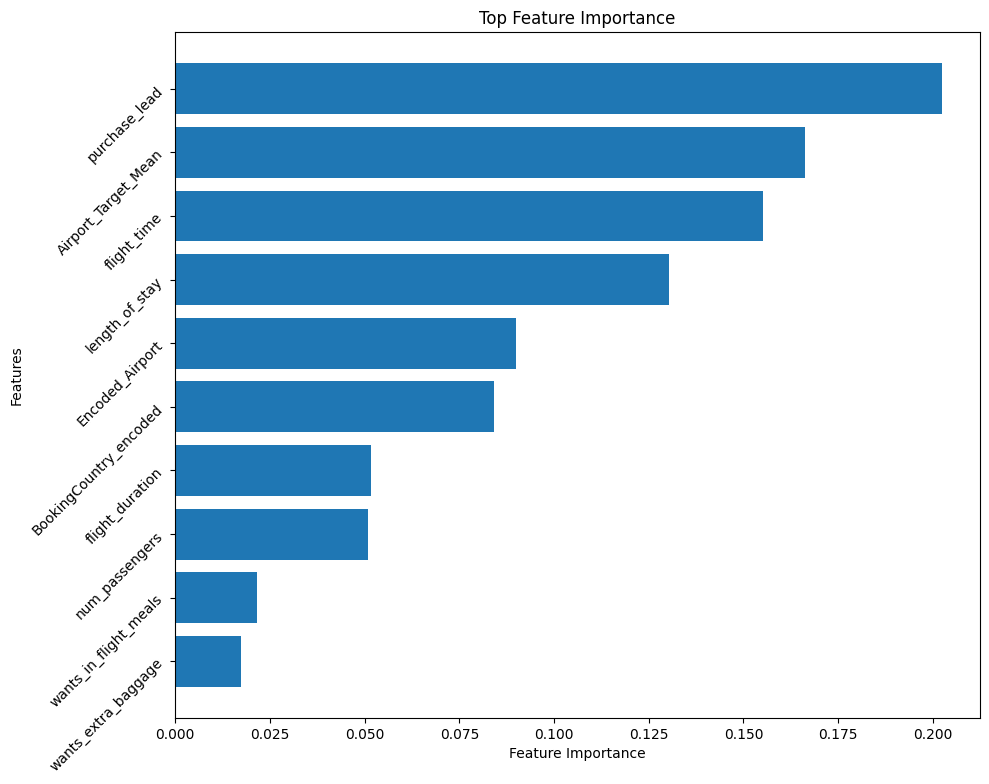

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the testing data
y_pred = model.predict(X_test)

# Display classification report and confusion matrix
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
output_path = 'Confusion Matrix.png'
plt.savefig(output_path, dpi=300)
plt.show()

# Feature Importance: Visualize how each variable contributed to the model
feature_importance = model.feature_importances_
sorted_idx = feature_importance.argsort()

# Increase the figure size
plt.figure(figsize=(10, 8))

# Display only the top N features
num_features = 10  # Desired number of top features
plt.barh(range(num_features), feature_importance[sorted_idx][-num_features:], align='center')

# Rotate y-axis labels by 45 degrees
plt.yticks(range(num_features), X.columns[sorted_idx][-num_features:], rotation=45)

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top Feature Importance')
plt.tight_layout()  # To ensure proper spacing
output_path = 'Feature Importance.png'
plt.savefig(output_path, dpi=300)
plt.show()

Some more methods


In [11]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

X = data.drop('booking_complete', axis=1)
y = data['booking_complete']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# RandomOverSampler and RandomUnderSampler
over_sampler = RandomOverSampler(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)

# Apply the sampling techniques to the training data
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

# Train a classifier using the original data
clf_original = RandomForestClassifier(random_state=42)
clf_original.fit(X_train, y_train)
y_pred_original = clf_original.predict(X_test)

# Train a classifier using the oversampled data
clf_over = RandomForestClassifier(random_state=42)
clf_over.fit(X_train_over, y_train_over)
y_pred_over = clf_over.predict(X_test)

# Train a classifier using the undersampled data
clf_under = RandomForestClassifier(random_state=42)
clf_under.fit(X_train_under, y_train_under)
y_pred_under = clf_under.predict(X_test)

print("Original Data:")
print(classification_report(y_test, y_pred_original))

print("Oversampled Data:")
print(classification_report(y_test, y_pred_over))

print("Undersampled Data:")
print(classification_report(y_test, y_pred_under))


Original Data:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     10648
           1       0.53      0.18      0.26      1852

    accuracy                           0.85     12500
   macro avg       0.70      0.57      0.59     12500
weighted avg       0.82      0.85      0.82     12500

Oversampled Data:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     10648
           1       0.44      0.29      0.35      1852

    accuracy                           0.84     12500
   macro avg       0.66      0.61      0.63     12500
weighted avg       0.82      0.84      0.83     12500

Undersampled Data:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     10648
           1       0.30      0.75      0.43      1852

    accuracy                           0.70     12500
   macro avg       0.62      0.72      0.62     12500
weighted avg       0.8